In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(5)

In [2]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    
    return np.array(inputs), np.array(labels).reshape(n, 1)

In [3]:
def generate_XOR_easy():
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1 * i, 0.1 * i])
        labels.append(0)
        
        if 0.1 * i == 0.5:
            continue
            
        inputs.append([0.1 * i, 1 - 0.1*i])
        labels.append(1)

    return np.array(inputs), np.array(labels).reshape(21, 1)

In [4]:
def plot_data(X, y, pred_y):
    print("Acc: ", 1 - np.mean(abs(y - pred_y)))
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 10))
    color_real = ['red' if l == 0 else 'green' for l in y]
    color_pred = ['red' if l == 0 else 'green' for l in pred_y]
    
    ax[0].scatter(X[:, 0], X[:, 1], color=color_real)
    ax[0].set_aspect("equal")
    ax[0].title.set_text("real")

    ax[1].scatter(X[:, 0], X[:, 1], color=color_pred)
    ax[1].title.set_text("predict")
    ax[1].set_aspect("equal")
    plt.show()

In [164]:
b = 15
a = list(range(0, 100, b))
if a[-1]  != 99:
    a.append(100)

In [166]:
a

[0, 15, 30, 45, 60, 75, 90, 100]

In [296]:
class Model():
    # input is 3d(x, y coordinate + 1 for bias), output is 1d
    # 2 hidden layer, 2 neurons for each
    class Layer():
        def __init__(self, size):
            self.d_a_hat = 0
            self.d_a = 0
            self.W = np.random.random(size) / 2
            self.b = np.random.random((1, size[1])) / 2
            self.a_hat = 0
            self.Wm = np.zeros(size)
            self.bm = np.zeros((1, size[1]))
                        
    def __init__(self):
        self.layer = []
    
    def add_layer(self, size):
        l = self.Layer(size)
        self.layer.append(l)
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def derivative_sigmoid(self, x):
        return np.multiply(x, 1.0 - x)
    
    def cal_loss(self, y, pred_y):
        # using cross entropy
#         return (1/2) * np.mean(sum(pow(pred_y - y, 2)))
        return np.mean(-(y * np.log(pred_y) + (1 - y) * np.log(1 - pred_y)))
    
    
    def derivative_loss(self, y, pred_y, batch_size):
#         return (pred_y - y) / batch_size
        return ((-y / pred_y) + (1 - y) / (1 - pred_y))/batch_size
    
    def update_W(self, x, y, pred_y, lr, batch_size):
        num_layer = len(self.layer)
        for i in range(num_layer)[::-1]:
            cur_layer = self.layer[i]
            if i == num_layer - 1:
                cur_layer.d_a_hat = self.derivative_loss(y, pred_y, batch_size)
            else:
                cur_layer.d_a_hat = self.layer[i+1].d_a @ self.layer[i+1].W.T
            cur_layer.d_a = cur_layer.d_a_hat * self.derivative_sigmoid(cur_layer.a_hat)
                         
        for i in range(num_layer):
            cur_layer = self.layer[i]
            if i == 0:
                grad = -lr * np.atleast_2d(x).T @ cur_layer.d_a
            else:
                grad = -lr * self.layer[i-1].a_hat.T @ cur_layer.d_a
            cur_layer.W += grad + cur_layer.Wm
            cur_layer.Wm = cur_layer.Wm * 0.9 + grad * 0.1
            
#             print(np.atleast_2d(np.sum(cur_layer.d_a, axis=0)).shape)
#             grad_b = -lr * np.mean(np.atleast_2d(np.sum(cur_layer.d_a, axis=0)))
            grad_b = -lr * np.atleast_2d(np.sum(cur_layer.d_a, axis=0))
            cur_layer.b += grad_b + cur_layer.bm
            cur_layer.bm = cur_layer.bm * 0.9 + grad_b * 0.1
            

    
    def preprocess_x(self, X_train):
        # add bias term
        X_train = np.hstack((X_train, np.ones(X_train.shape[0]).reshape(-1, 1)))
        return X_train
        
    def train(self, X_train, y_train, lr, batch_size=5, iteration=100):        
        loss_acc = []
        batch = list(range(0, X_train.shape[0], batch_size))
        if batch[-1] != X_train.shape[0]:
            batch.append(X_train.shape[0])
        
        for i in range(iteration):
            pred_y = []
#             for x, y in zip(X_train, y_train):
            for k in range(len(batch)-1):
                x = X_train[batch[k]:batch[k+1]]
                y = y_train[batch[k]:batch[k+1]]
                in_data = np.atleast_2d(x)
                for j in range(len(self.layer)):
                    self.layer[j].a_hat = self.sigmoid((in_data @ self.layer[j].W) + self.layer[j].b)
                    in_data = self.layer[j].a_hat
                        
                y_hat = in_data
                loss = self.cal_loss(y, y_hat)
                self.update_W(x, y, y_hat, lr, batch_size)
                pred_y.extend(y_hat)
            
            pred_y = np.array(pred_y)
            loss = np.mean(self.cal_loss(y_train, pred_y))
            loss_acc.append(loss)
            if i % 1000 == 0:
                print("epoch", i, ":", loss)
                
        return loss_acc
        
    def predict(self, X):
        pred_y = []
        for x in X:
            in_data = np.atleast_2d(x)
            for j in range(len(self.layer)):
                self.layer[j].a_hat = self.sigmoid((in_data @ self.layer[j].W) + self.layer[j].b)
                in_data = self.layer[j].a_hat

            pred_y.extend(in_data)
        return np.round(np.array(pred_y))

epoch 0 : 0.6914168216057536
epoch 1000 : 0.6769615488387918
epoch 2000 : 0.03937757186875189
epoch 3000 : 0.018881404161340237
epoch 4000 : 0.011713747142756546
epoch 5000 : 0.008015855346749689
epoch 6000 : 0.00584651683101252
epoch 7000 : 0.004472537700299689
epoch 8000 : 0.0035504506989009503
epoch 9000 : 0.0029020773298589642
epoch 10000 : 0.0024283605710724745
epoch 11000 : 0.002071074428959942
epoch 12000 : 0.0017943366897571911
epoch 13000 : 0.0015751160072062793
epoch 14000 : 0.0013980988846750704
epoch 15000 : 0.001252786013166006
epoch 16000 : 0.0011317828907006246
epoch 17000 : 0.0010297572526567792
epoch 18000 : 0.0009427828360448211
epoch 19000 : 0.0008679145244285674
Acc:  1.0


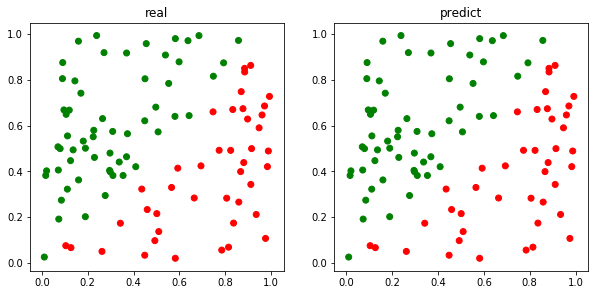

In [297]:
lr = 0.3
batch_size=100
X, y = generate_linear()
m = Model()
m.add_layer((2, 2))
m.add_layer((2, 2))
m.add_layer((2, 1))
loss = m.train(X, y, lr, batch_size, iteration=20000)
pred_y = m.predict(X)
plot_data(X, y, pred_y)

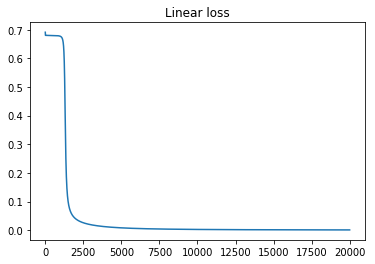

In [298]:
plt.plot(loss)
plt.title("Linear loss")
plt.show()

epoch 0 : 0.6975731412457817
epoch 1000 : 0.6920104295234569
epoch 2000 : 0.6920093662393032
epoch 3000 : 0.6920079372139212
epoch 4000 : 0.6920058934283777
epoch 5000 : 0.6920027552494424
epoch 6000 : 0.6919974905079328
epoch 7000 : 0.691987526641166
epoch 8000 : 0.6919649484872403
epoch 9000 : 0.6918958679756826
epoch 10000 : 0.6915202587796715
epoch 11000 : 0.6809871601035491
epoch 12000 : 0.27253187067898754
epoch 13000 : 0.16586839748733942
epoch 14000 : 0.16151412331041426
epoch 15000 : 0.160629336612815
epoch 16000 : 0.1602786566761179
epoch 17000 : 0.16017370838080222
epoch 18000 : 0.16009331897428725
epoch 19000 : 0.16001191688326696
epoch 20000 : 0.15995192345200088
epoch 21000 : 0.15990595461514184
epoch 22000 : 0.15986964593929662
epoch 23000 : 0.15984026713914337
epoch 24000 : 0.15981602333253547
epoch 25000 : 0.1597956873875624
epoch 26000 : 0.1597783925952067
epoch 27000 : 0.1597635097891676
epoch 28000 : 0.15975057141618804
epoch 29000 : 0.15973922291934278
epoch 30000 

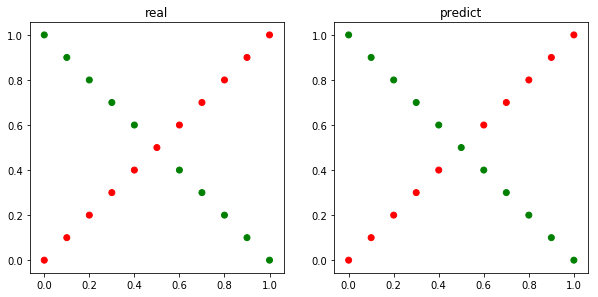

In [299]:
lr = 0.4
X, y = generate_XOR_easy()
m = Model()
m.add_layer((2, 2))
m.add_layer((2, 2))
m.add_layer((2, 1))
loss = m.train(X, y, lr, batch_size=21, iteration=100000)
pred_y = m.predict(X)
plot_data(X, y, pred_y)

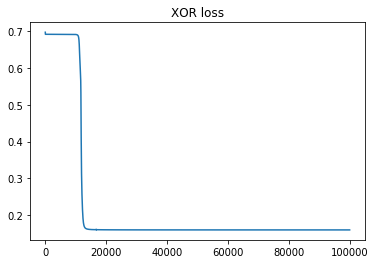

In [300]:
plt.plot(loss)
plt.title("XOR loss")
plt.show()